In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#1. Excel dosyasını oku
df = pd.read_excel("mevduatveri.xlsx")

#İlk 5 satırı göster
df.head()

,musteri_id,musteri_tipi,para_birimi,vade_gunu,mevduat_tutari,baslangic_faizi,piyasa_faizi,kur,erken_kapatti,sure
0,1,Bireysel,TL,174,60500,23.11,24.56,32.12,0,174
1,2,Ticari,TL,230,173800,27.04,12.16,23.24,1,226
2,3,Bireysel,TL,241,47000,27.65,23.71,27.00,0,241
3,4,Bireysel,USD,249,379100,22.46,11.84,32.25,0,249
4,5,Bireysel,TL,269,143400,25.25,29.30,21.01,1,177


In [18]:
from sksurv.datasets import get_x_y
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sksurv.nonparametric import kaplan_meier_estimator

In [ ]:
# Kaplan Meier Yöntemi:

# AMAÇ: "Zaman geçtikçe olayın (örneğin vadeli mevduatın erken kapanması),
# gerçekleşmeden önce hayatta (aktif) kalma olasılığı nedir?"

#(İlk 30 günde müşterilen %90'ı hala hesabı kapatmamış. 60 gün sonunda bu oran %72'ye düşmüş gibi)

# Kaplan-Meier Formülü:

# S(t)=∏_(i:t_i≤t)▒(1-d_i/n_i )

#Bu, her olay anında (ti) hayatta kalan oranı al ve hepsini çarp. O ana kadar hayatta kalma olasılığını bul.
#Kaplan-Meier, her olay anında hayatta kalan oranı hesaplar ve zaman boyunca bunları çaprarak hayatta kalma eğrisini oluşturur.

# S(t): t anına kadar hayatta kalma olasılığı
# di: o anda olay yaşayan kişi sayısı
# ni: o anda hala riskte olan kişi sayısı

#Cencored Durumlar:
#Örneğin C ve E müşterileri olayı yaşamadan gözlemden çıktılar (vade sonuna kadar kaldılar)
#Cencored olanlar eğriyi düşürmez ama risk grubunda sayılır.

#SONUÇ:
#Eğri basamaklıdır (her olayda düşer).
#Hızlı düşerse erken kapama eğilimi fazladır.
#Düz kalırsa olay gerçekleşmemiştir.

#ÖZET:
#Modeli ihtiyacı:
#Süre (t): Olay gerçekleşene kadar geçen zaman
#Event (1/0): Olay gerçekleşti mi?
#S(t): Zamanla hayatta kalma olasılığı

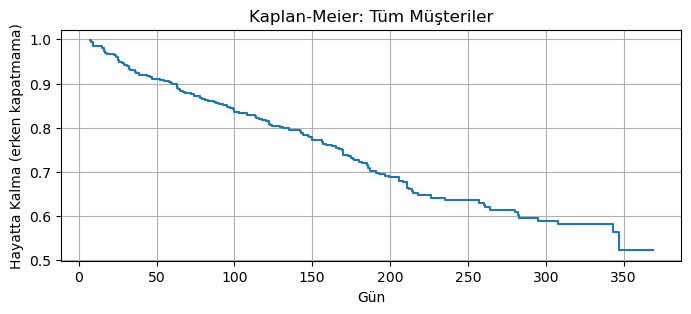

In [22]:
#2. Kaplan-Meier Analizi (Genel)
# Sağkalım modeli için hedef değişken (event) ve süre (time) tanımlanıyor.
#Kaplan_meier_estimator ile tüm müşteri verisi için sağkalım eğrisi üretiliyor.
event = df["erken_kapatti"].astype(bool)
time = df["sure"]
t_all, s_all = kaplan_meier_estimator(event, time)


plt.figure(figsize=(8, 3))
plt.step(t_all, s_all, where="post")
plt.title("Kaplan-Meier: Tüm Müşteriler")
plt.xlabel("Gün")
plt.ylabel("Hayatta Kalma (erken kapatmama)")
plt.grid(True)
plt.show()

In [ ]:
#Grafik Yorumu
# Y EKSENİ: Hayatta kalma olasılığı = Vadeli mevduatın hala bozulmadan durma oranı
# X EKSENİ: Gün = Mevduatın açılışından bu yana geçen süre
#1.0: %100 müşteri hala kapatmamış (herkes vadeye sadık, kimse kapatmamış)
#0.7: %70 müşteri hala vadeyi bzomadı, %30'u bozdu demektir.
#Günler ilerledikçe eğri aşağı doğru iniyor, erken kapanmalar başlıyor
#Örneğin; Gün 50'de Y = 0.94 (%6'sı vadeden önce kapatmış)
#Gün 150 civarında Y=0.76 (%24'ü erken kapatmış)
#Özet Yorum: Müşterilerin büyük kısmı zamanla vadeli mevduatını erken kapatıyor.
#300 gün sonunda %55'ten fazlası parayı vadesinden önce çekmiş.

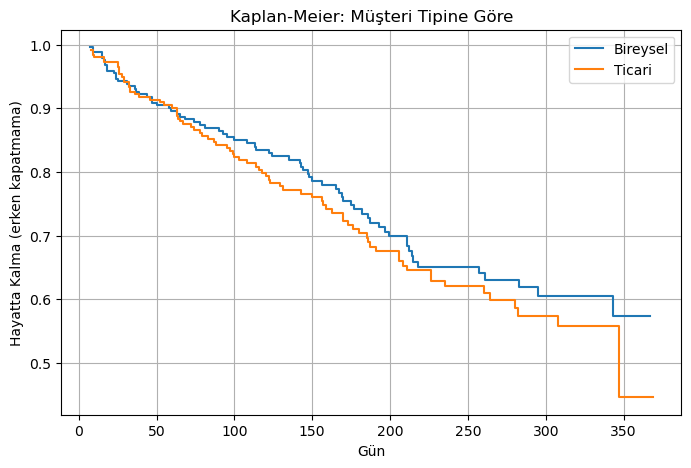

In [5]:
#3. Kaplan-Meier: Müşteri Tipine Göre
# Her müşteri tipi için ayrı sağkalım eğrisi çizer.
# Erken kapatma eğilimleri segment bazında karşılaştırılabilir.
plt.figure(figsize=(8, 5))
for tip in df["musteri_tipi"].unique():
    mask = df["musteri_tipi"] == tip
    t, s = kaplan_meier_estimator(event[mask], time[mask])
    plt.step(t, s, where="post", label=tip)
plt.title("Kaplan-Meier: Müşteri Tipine Göre")
plt.xlabel("Gün")
plt.ylabel("Hayatta Kalma (erken kapatmama)")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
#4. Ortalama sağkalım süresi (erken kapatmama)
# Kaplan-Mier eğrisinden ortalama vadede kalma süresi hesaplanır.
#Bu, müşterilerin erken kapatmama yönünde ortalama ne kadar dayandığını gösterir.
#t_all: günler, s_all: O günlerdeki hayatta kalma (kapatmama) olasılığı
#Yani, her gün için "kaç gün kaldı x o günkü hayatta kalma ihtimali" hesaplanıp toplanıyor.

expected_time = sum((t1 - t0) * s for t0, t1, s in zip([0] + list(t_all[:-1]), t_all, s_all))
print(f"Kaplan-Meier ile ortalama erken kapatmama süresi: {expected_time:.1f} gün")

Kaplan-Meier ile ortalama erken kapatmama süresi: 270.0 gün


In [ ]:
# Çıktı Yorumu: Müşteriler vadeli mevduatlarını ortalama 270 gün boyunca bozmazlar.
#Yani, hayatta kalma süresi = mevduatın kapatılmadan bankada kaldığı süre.
#Bu ortalama, erken kapatan ve hiç kapatmayanları birlikte dikkate alır.

In [8]:
#4.1 Erken Kapatma Oranı
# En uzun sürede hayatta kalan (kapatmayan) müşterilerin oranı alınır.
# Kalan %'lik kısmın erken kapattığı sonucu çıkarılır.

#s_all[-1]: Kaplan-meier eğrisinin sonundaki hayatta kalma oranı (%52.3)
#Bundan 1 çıkarınca erken kapatma oranı = %47.7 bulunuyor.


final_survival_prob = s_all[-1] #En son sağkalım oranı
early_closure_rate = 1 - final_survival_prob
print(f"Kaplan-Meier ile erken kapatma oranı: %{early_closure_rate * 100:.1f}")

Kaplan-Meier ile erken kapatma oranı: %47.7


In [ ]:
# Çıktı Yorumu: Müşterilerin %47.7'si vade dolmadan mevduatını bozmuş.

In [23]:
#5. Cox Model
#Event ve süre sütunları
y = Surv.from_dataframe("erken_kapatti", "sure", df)

#Kullanılacak değişkenler (ID Hariç, event/duration hariç)
X = df.drop(columns=["musteri_id", "erken_kapatti", "sure"]) #Analize katılacak bağımsız değişkenler

In [11]:
#Kategorik değişkenler one-hot encoding ile sayısala çevrilir.
#Pipeline içinde Cox modeli tanımlanır ve eğitilir.

#Kategorik Sütunlar
categorical_cols = ["musteri_tipi", "para_birimi"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

#One-hot encoder
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), categorical_cols)
], remainder="passthrough")

#Cox Modeli pipeline ile
pipeline = make_pipeline(
    preprocessor,
    CoxPHSurvivalAnalysis()
)

#Modeli eğit
pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['musteri_tipi',
                                                   'para_birimi'])])),
                ('coxphsurvivalanalysis', CoxPHSurvivalAnalysis())])

In [12]:
#Cox Model Çıktısı
#Pipeline içinden model bileşenini çekelim
cox_model = pipeline.named_steps["coxphsurvivalanalysis"]
ohe = pipeline.named_steps['columntransformer'].transformers_[0][1]
cat_features = ohe.get_feature_names_out(categorical_cols)
all_features = list(cat_features) + numeric_cols

In [15]:
#Katsayıları göster
coef_df = pd.Series(cox_model.coef_, index=all_features).sort_values(ascending=False)
print("\n--- Cox Modeli Katsayıları ---")
print(coef_df)


--- Cox Modeli Katsayıları ---
para_birimi_USD        1.554836e-01
musteri_tipi_Ticari    8.908207e-02
baslangic_faizi        2.599725e-03
mevduat_tutari         7.523649e-07
vade_gunu             -6.498632e-03
kur                   -8.358633e-03
piyasa_faizi          -1.638535e-02
dtype: float64


In [ ]:
# Cox Model Katsayı Yorumlama:
# Cox model formu:
# h(t|x) = h0(t).exp(B1x1 + B2x2 + ...)

# Bu durumda:
# B: tahmin edilen katsayı
# exp(B): hazard ratio (yani "rölatif risk")
# "Yani: Değişken 1 birim artarsa, risk (erken kapatma olasılığı) exp(B) katına çıkar."



# Katsayı > 0 : O değişkenin değeri arttıkça erken kapatma riski artar.
# Katsayı < 0 : O değişkenin değeri arttıkça erken kapatma riski azalır (Yani vadesine daha çok sadık)

#Vadeli mevduat USD cinsindeyse, erken kapatma riski yüksek. Kur etkisi, belirsizlik veya fırsat maliyeti daha yüksek olabilir.
#Müşleriler USD hesabı daha kolay bozuyor. Bağımsız değişken 1 birim değiştiğinde, 
#bağımlı değişken (erken kapatma riski (hazard rate)) üzerinde exp(1.5548)=1.17 daha fazla.
# USD hesaplarda erken kapatma riski %17 daha fazla diğer döviz cinslerine göre.
# Burada para_birimi değişkeni dummy değişken haline getirildiği için karşılaştırma şeklinde bakılır.